**Test with one subject and other subjects are training data**

**This one will be used for android application**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [5]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
#!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

 acc_data_4sec_before_3sec_after.csv
 acc_data_4sec_before_3sec_after_with_magnitude.csv
 accelerometer_extracted_featured_data_without_overlapping.csv
'Additional Testing Code'
'Basic Data'
 checkpoint
 converted_model.tflite
 frozen_har.pb
 history.p
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 predictions.p
'Processed Data'


# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sn

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

# Load Data

In [0]:
#columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_without_overlapping.csv')
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_consecutive_activity_without_overlapping.csv')
#, header = None, names = columns
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538 entries, 0 to 2537
Data columns (total 33 columns):
mean_x              2538 non-null float64
mean_y              2538 non-null float64
mean_z              2538 non-null float64
magnitude_mean      2538 non-null float64
std_x               2538 non-null float64
std_y               2538 non-null float64
std_z               2538 non-null float64
magnitude_std       2538 non-null float64
rms_x               2538 non-null float64
rms_y               2538 non-null float64
rms_z               2538 non-null float64
magnitude_rms       2538 non-null float64
min_x               2538 non-null float64
min_y               2538 non-null float64
min_z               2538 non-null float64
magnitude_min       2538 non-null float64
max_x               2538 non-null float64
max_y               2538 non-null float64
max_z               2538 non-null float64
magnitude_max       2538 non-null float64
median_x            2538 non-null float64
median_y   

# Data Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

In [9]:
df.head()
#print(df['mean_x'])
#print(df['mean_x'].values[0])


,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873054,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
2,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING
3,-4.440626,1.069510,-8.864417,9.972461,0.071734,0.047943,0.063884,0.049366,4.441206,1.070584,8.864647,9.972584,-4.570816,0.944107,-8.995804,9.865092,-4.271545,1.226624,-8.758789,10.071942,-4.436752,1.070999,-8.861740,9.964040,0.059195,0.035829,0.051725,0.042919,0.194947,0.208995,-0.454511,2,SITTING
4,-4.375648,0.917478,-8.933562,9.991692,0.120399,0.155448,0.059223,0.069623,4.377304,0.930554,8.933758,9.991934,-4.709686,0.434143,-9.072418,9.695230,-3.852570,1.159576,-8.753998,10.174546,-4.358940,0.938118,-8.938354,10.006441,0.077469,0.110670,0.045394,0.043270,-0.026265,0.537605,-0.009120,2,SITTING


['SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


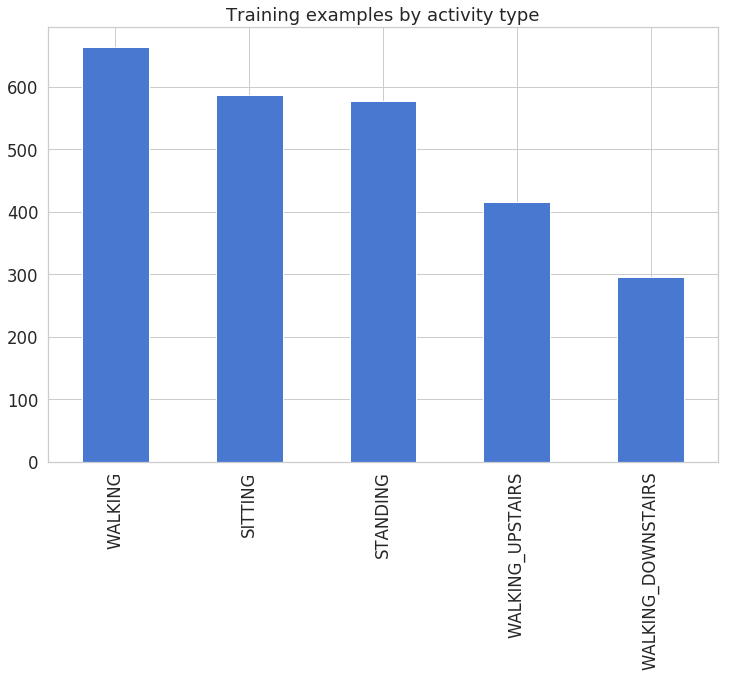

In [10]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');
unique_activities = np.unique(df['class'])
print(unique_activities)

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

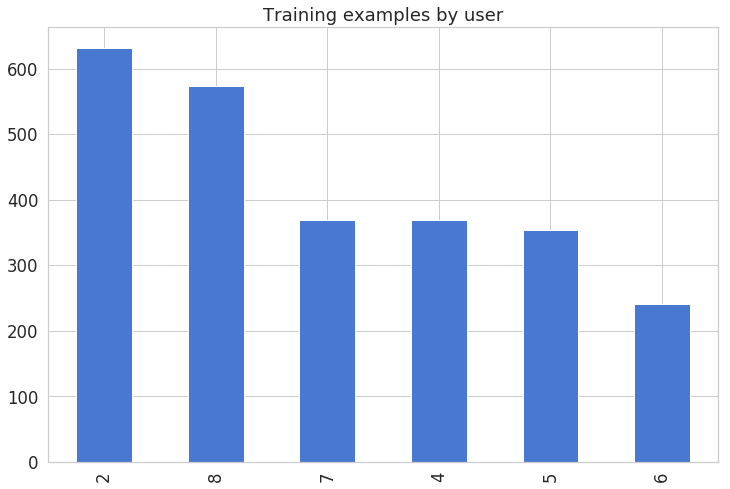

In [11]:
df['subject'].value_counts().plot(kind='bar', title='Training examples by user');

In [0]:
def plot_activity(subject, activity, df, activity_name):
  
  one_subject_segdata = df.loc[df['subject'] == subject]
  data = one_subject_segdata[one_subject_segdata['class'] == activity][['mean_x', 'mean_y',]][:100]
  axis = data.plot(subplots=True, figsize=(18, 14), 
                   title= 'Subject: '+str(subject) + ' Activity: '+activity_name)
  for ax in axis:
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

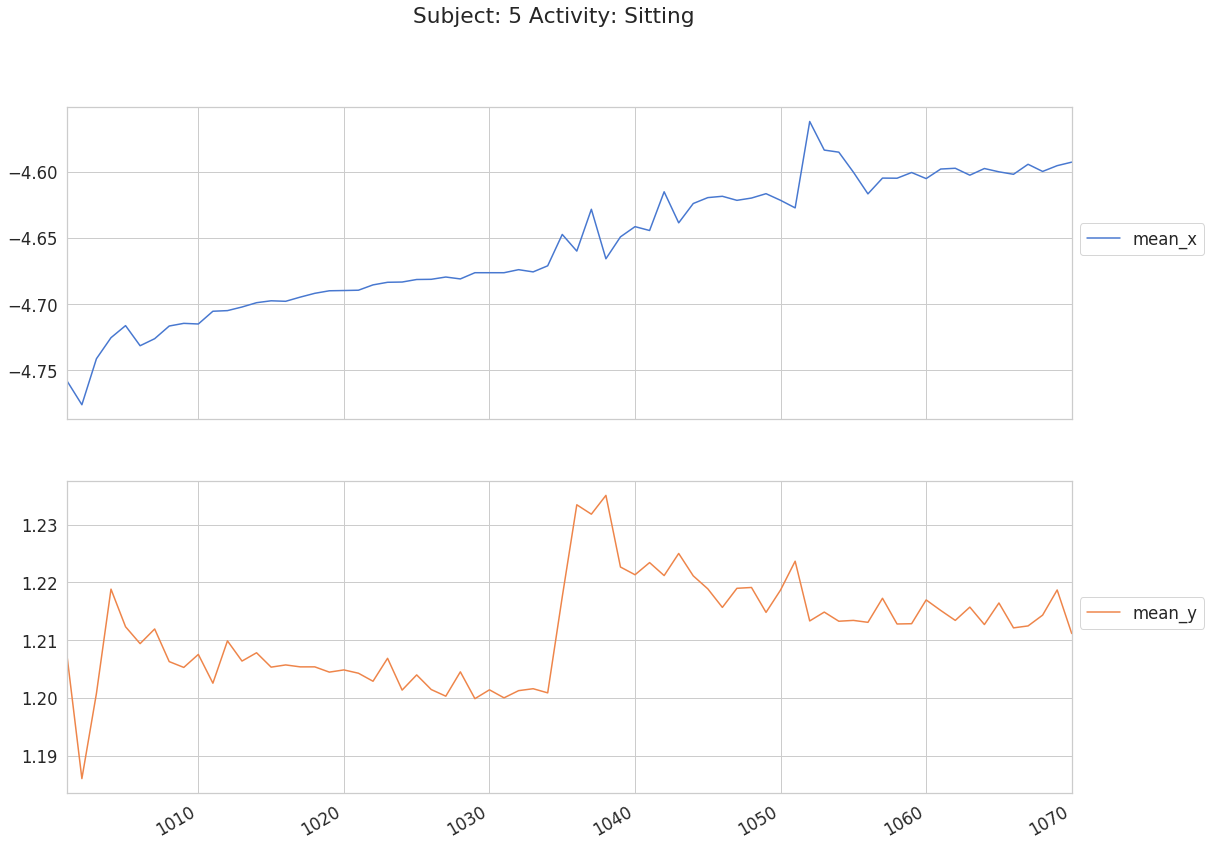

In [13]:
#plot_activity("Sitting", df)
plot_activity(5,"SITTING", df, "Sitting")

# Data Preprocessing

In [14]:
unisubs = np.unique(df['subject'])
#unisubs = np.asarray([2,5,6,7])
print(unisubs)


#one_subject_segdata = df.loc[df['subject'] == unisubs[i]]


[2 4 5 6 7 8]


In [15]:
data = df.values
print(len(data), len(df), data.shape)
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:,-1].astype('str'))+1

subjects = np.unique(df['subject'])
print(subjects)

activity_ids = np.unique(y)
n_class = len(activity_ids)
print(activity_ids)

2538 2538 (2538, 33)
[2 4 5 6 7 8]
[1 2 3 4 5]


In [0]:
columns = ['mean_x', 'mean_y', 'mean_z', 'magnitude_mean',
            'std_x', 'std_y', 'std_z', 'magnitude_std',
            'rms_x', 'rms_y', 'rms_z', 'magnitude_rms',
            'min_x', 'min_y', 'min_z', 'magnitude_min',
            'max_x', 'max_y', 'max_z', 'magnitude_max',
            'median_x', 'median_y', 'median_z', 'magnitude_median',
            'mad_x', 'mad_y', 'mad_z','magnitude_mad',
           'corr_xy','corr_yz', 'corr_xz',
            'subject',  'class']

N_TIME_STEPS = 2
N_FEATURES = 31
step = 5

In [0]:

def make_sequence(data):
  
  segments = []
  labels = []
  
  for i in range(0, len(data) - N_TIME_STEPS, step):
    sequence_array= []
    for j in range (0, len(columns)-2):
      sequence_array.append(data[columns[j]].values[i: i + N_TIME_STEPS])
    segments.append(sequence_array)
    
    #xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    #ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    #zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data['class'][i: i + N_TIME_STEPS])[0][0]
    #segments.append([xs, ys, zs])
    labels.append(label)
  
  return segments, labels

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [19]:
unisubs = np.unique(df['subject'])
print(unisubs)

subject = 7

train_data = df.loc[df['subject'] != subject]
test_data = df.loc[df['subject'] == subject]

print(len(train_data), len(test_data))

[2 4 5 6 7 8]
2169 369


In [20]:
train_segments, train_labels = make_sequence(train_data)
test_segments, test_labels = make_sequence(test_data)

print(len (train_data),np.asarray(train_segments).shape, type(train_labels), np.asarray(train_labels).shape)
print(len (test_data),np.asarray(test_segments).shape,type(test_labels), np.asarray(test_labels).shape)



reshaped_train_segments = np.asarray(train_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
train_labels = np.asarray(pd.get_dummies(train_labels), dtype = np.float32)

reshaped_test_segments = np.asarray(test_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
print(reshaped_train_segments.shape, len(train_labels))
print(reshaped_test_segments.shape, len(test_labels))

X_train = reshaped_train_segments
y_train =  train_labels
X_test = reshaped_test_segments
y_test = test_labels
  
  
  
print(type (X_train), X_train.shape, type (y_train), y_train.shape,)
print(type(X_test), X_test.shape, type(y_test), y_test.shape)
#print (len(X_train), len(y_train), len(X_test), len(y_test))

print(y_test[0])

#print(X_test[0])

2169 (434, 31, 2) <class 'list'> (434,)
369 (74, 31, 2) <class 'list'> (74,)
(434, 2, 31) 434
(74, 2, 31) 74
<class 'numpy.ndarray'> (434, 2, 31) <class 'numpy.ndarray'> (434, 5)
<class 'numpy.ndarray'> (74, 2, 31) <class 'numpy.ndarray'> (74, 5)
[1. 0. 0. 0. 0.]


# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [0]:
N_CLASSES = 5
N_HIDDEN_UNITS = 32

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    
    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    lstm_layers = [tf.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.nn.rnn_cell.MultiRNNCel(lstm_layers)
    outputs, _ = tf.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [24]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [25]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Finally, let's define optimizer and accuracy ops:

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [0]:
N_EPOCHS = 50
BATCH_SIZE = 16

In [28]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    '''
    if i != 1 and i % 10 != 0:
        continue
    '''
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')


epoch: 1 test accuracy: 0.7567567825317383 loss: 1.6944385766983032
epoch: 2 test accuracy: 0.8783783912658691 loss: 1.382009744644165
epoch: 3 test accuracy: 0.8513513803482056 loss: 1.292811632156372
epoch: 4 test accuracy: 0.9054054021835327 loss: 1.1994054317474365
epoch: 5 test accuracy: 0.9594594836235046 loss: 1.1428313255310059
epoch: 6 test accuracy: 0.9189189076423645 loss: 1.1462924480438232
epoch: 7 test accuracy: 0.9594594836235046 loss: 1.0718433856964111
epoch: 8 test accuracy: 0.9189189076423645 loss: 1.0670781135559082
epoch: 9 test accuracy: 0.9324324131011963 loss: 1.0014545917510986
epoch: 10 test accuracy: 0.9189189076423645 loss: 0.9859591722488403
epoch: 11 test accuracy: 0.8918918967247009 loss: 0.9818836450576782
epoch: 12 test accuracy: 0.9054054021835327 loss: 0.9177643060684204
epoch: 13 test accuracy: 0.9189189076423645 loss: 0.8898223638534546
epoch: 14 test accuracy: 0.8918918967247009 loss: 0.9158049821853638
epoch: 15 test accuracy: 0.9054054021835327 l

In [29]:
print(activity_ids)
activity_ids = np.unique(y)-1
print(activity_ids)

[1 2 3 4 5]
[0 1 2 3 4]


In [0]:
def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

<class 'numpy.ndarray'> (74, 5) [1. 0. 0. 0. 0.]
<class 'numpy.ndarray'> (74,) 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4]
<class 'numpy.ndarray'> (74,) [4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 3 2 2 2 3 2 4 2 2 2 2 2 2 2 4 4 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4]
accuracy  0.918918918918919
precision, recall, f1score, accuracy
0.9351351351351351 0.918918918918919 0.9207838690011865 Tensor("Mean_1:0", shape=(), dtype=float32)
class-wise precision: [1.   1.   1.   0.8  0.75]
class-wise recall: [0.9375     1.         0.80952381 0.88888889 1.        ]
class-wise f1score: [0.96774194 1.         0.89473684 0.84210526 0.85714286]
class-wise accuracy: [0.9375     1.         0.80952381 0.88888889 1.        ]
[[15  0  0  0  1]
 [ 0 16  0  0  0]
 [ 0  0 17  2  2]
 [ 0  0  0  8  1]
 [ 0  0  0  0 12]]


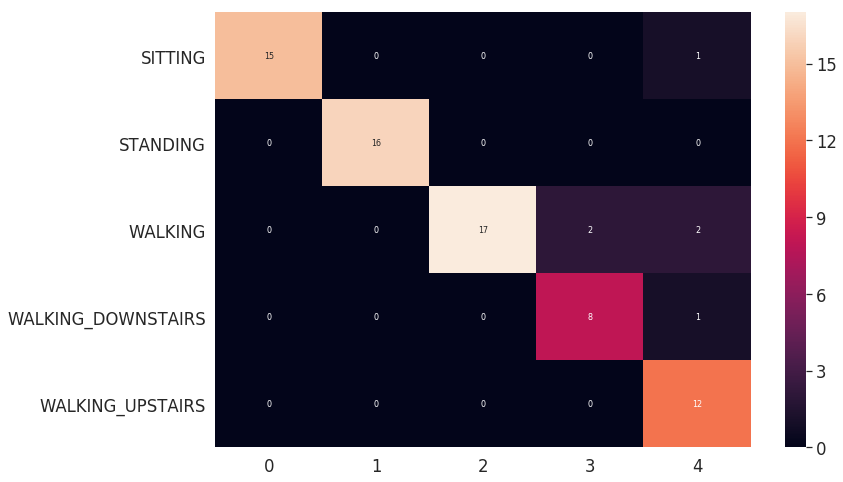

In [31]:
print(type(y_test), y_test.shape, y_test[0])

test_y = np.argmax(y_test, axis=1)
print(type(test_y), test_y.shape, test_y[0])
print(test_y)



#print(predictions)
#print(type(predictions), predictions.shape, predictions[0])
l= np.argmax(predictions, axis=1)
#print (type(l), l.shape, l)
#print (type(l), l.shape)

pred = activity_ids[np.argmax(predictions, axis=1)]
print(type(pred),pred.shape, pred)


acc = accuracy_score(test_y, pred)

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
print('accuracy ', acc)
print("precision, recall, f1score, accuracy")
print( precision,recall,f1score,accuracy)

cm_all = confusion_matrix(test_y, pred)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))

#array = confusion_matrix(true_all, pred_all)
array = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()


In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))

Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [33]:

#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "checkpoint/har.ckpt")


'''
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'har.pbtxt')  
saver.save(sess, save_path = "har.ckpt")
sess.close()


'''

'\npickle.dump(predictions, open("predictions.p", "wb"))\npickle.dump(history, open("history.p", "wb"))\n#tf.train.write_graph(sess.graph_def, \'.\', \'./checkpoint/har.pbtxt\')  \n#saver.save(sess, save_path = "./checkpoint/har.ckpt")\n\ntf.train.write_graph(sess.graph_def, \'.\', \'har.pbtxt\')  \nsaver.save(sess, save_path = "har.ckpt")\nsess.close()\n\n\n'

In [0]:
sess.close()

And loading it back:

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

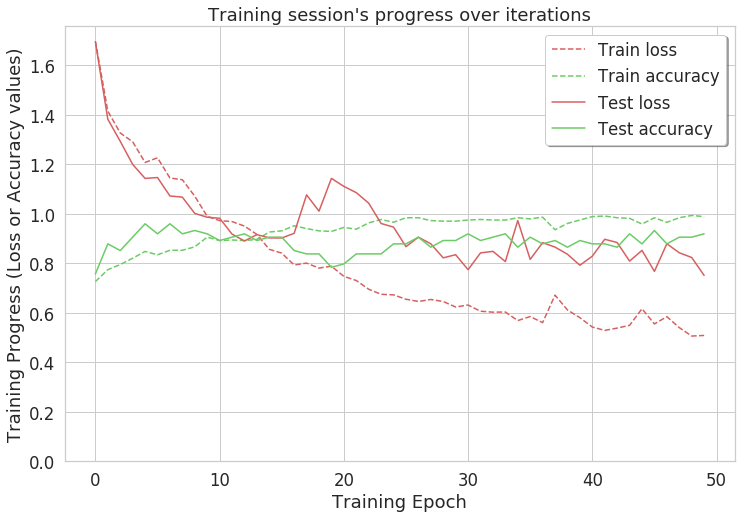

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [0]:
#LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

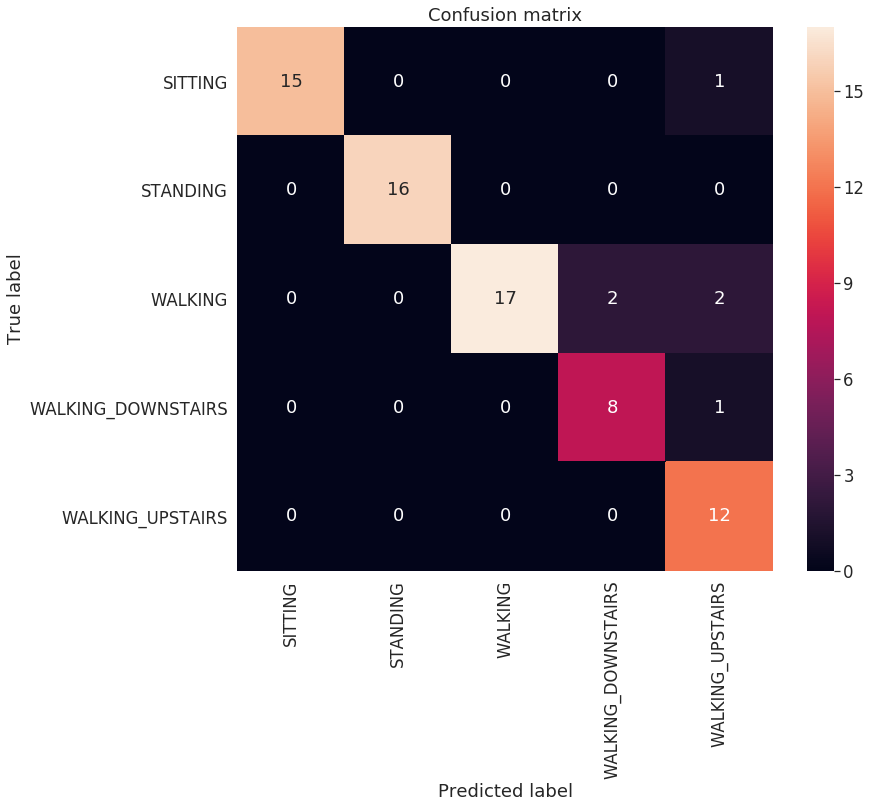

In [38]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [39]:
# tensprflow cpu VERSION 1.13.1
print(tf.__version__)

1.14.0


Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

# Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [40]:
from tensorflow.python.tools import freeze_graph

#MODEL_NAME = 'har'
MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
#output_frozen_graph_name = 'frozen_model_new2'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
        dim {
          size: 31
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 31
          }
          dim {
            size: 32
          }
        }
        tensor_content: "\335\360\220?\274\317C\275\254\036[\277\254a\215\275mc\036?\270\343\244\277\242\253\032\276p\303\242?\272u\017\277<\252\347>\217\300\215?\276\200(\2774\245\222\276HL[\2771\036\313>\343d\204?j\277K\277\200\020N\276\373h\035?^,\222\277c\007\2539\255\306>\277\220\256\227=\216\2540<\023[\221=\302\n[\277tO\027=[>\210<\244a\020\276\\\005\313>:\376\21

#convert to tflite model

In [41]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)

graph_def_file = 'frozen_'+MODEL_NAME+'.pb'
#graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

82868

In [42]:

# Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  #print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
#print (correct_case)
print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))

TensorFlow Lite Evaluation result is 0.918918918918919
